In [1]:
import numpy as np
import os
import scipy
from matplotlib import pyplot as plt
import healpy as hp
from astropy.cosmology import Planck18 as cosmo
import astropy.units as unit
import scipy.integrate as integrate
from scipy.interpolate import interp1d

f21 = 1.420405751e9 * unit.Hz

### Load shells as calculated from the mapping notebook. If the shells have resolution ~nside 1024 or greater, it may be necessary to load the shells individually into the notebook and then combine them into a single array.

In [21]:
shells = np.load("maps/mar_31/nside256_res100_len1000.npy")

In [3]:
nside = 256
nfreqs = 32

freqs = np.linspace(1.6e8 * unit.Hz, 1.8e8 * unit.Hz, nfreqs)
redshifts = (f21 / freqs) - 1


# must sort so that redshifts go in ascending order (opposite freq order)
z_order = np.argsort(redshifts)
f_order = np.argsort(freqs)
redshifts = redshifts[z_order]
redshifts = redshifts.to_value()
freqs = freqs[z_order]


### Calculate the angular cross-power spectrum between each shell. Because C_l(shell1, shell2) = C_l(shell2, shell1), we only calculate half of the total possible combinations.

In [4]:
cross_spectrum = np.zeros((nfreqs, nfreqs, nside*3))
for i in np.arange(shells.shape[0]):
    for j in np.arange(i + 1):
        cross_spectrum[i, j] = hp.sphtfunc.anafast(shells[i], shells[j])

In [5]:
# constants to be used in the equation for C_l(freq_1, freq_2) -> P(k_perp, k_los)
z_c = np.mean(redshifts)
r_c = cosmo.comoving_distance(z_c)
dr_c = -3e8 * (unit.m / unit.s) * (1+z_c) ** 2 / (f21 * cosmo.H(z_c))
dr_c = dr_c.to(unit.Mpc / unit.Hz)
delta_delta_freq = (freqs[-1] - freqs[0]) / nfreqs 
delta_d = cosmo.comoving_distance(redshifts[-1]) - cosmo.comoving_distance(redshifts[0])

### Create a dictionary of $\Delta \nu$: Each $\Delta \nu$ key contains a list of all the C_ls of shells with that frequency separation.

In [10]:
freq_dict = {}
for (idx_1, freq_1) in enumerate(freqs):
    for (idx_2, freq_2) in enumerate(freqs):
        
        # Round to avoid float equality issues.
        delta_freq = np.abs((freq_1 - freq_2).to_value().round(4)) # C_l(freq1 - freq2) = C_l(freq2 - freq1) 
        
        if np.any(cross_spectrum[idx_1][idx_2]):
            if delta_freq not in freq_dict:
                freq_dict[delta_freq] = [cross_spectrum[idx_1][idx_2]]
            else:
                freq_dict[delta_freq].append(cross_spectrum[idx_1][idx_2])

n_delta_freq = len(freq_dict.keys())

### Calculate $C_l^{EP}$

In [11]:
# For an ergodic signal, all of the C_l's in a given bin should be equal
# Average over each bin to reduce sample bias. 
C_ergs = np.asarray([np.mean(freq_dict[delta_freq], axis = 0) for delta_freq in freq_dict])

### Determine valid k_perp and k_los

In [12]:
box_len = 1000
res = 100

# npoints is somewhat arbitrary --determines the number of k_los bins.
npoints = 32

box_len = box_len * unit.Mpc

lmax = nside * 3

j=0
while (j / r_c < 1 / box_len):
    j+=1
    if j > lmax:
        print("box length is smaller than largest possible l.")
        break


k_perp_min = (j / r_c).to_value()
k_perp_max = (lmax / r_c).to_value()

delta_shell = cosmo.comoving_distance(redshifts[1]) - cosmo.comoving_distance(redshifts[0])

#1 convention
if delta_d > box_len:
    k_los_min = 2 * np.pi / box_len.to_value()
else:
    k_los_min = 2 * np.pi / delta_d.to_value()

if delta_shell > (box_len / res):
    k_los_max = 2* np.pi / delta_shell.to_value()
else:
    k_los_max = 2 * np.pi * (res / box_len).to_value()

k_los = np.logspace(np.log10(k_los_min), np.log10(k_los_max), npoints) * (unit.Mpc) ** -1

k_perp = (np.arange(lmax)[j::] / r_c)

### Compute P(k_perp, k_los)

In [13]:
pspec_rect_arr = np.empty((n_delta_freq, lmax - j, k_los.size), dtype=np.complex_)
for idx, delta_freq in enumerate(freq_dict):
    for l in (np.arange(j, lmax)):
        for k_idx, k in enumerate(k_los):
            pspec_rect_arr[idx, l - j, k_idx] = (delta_delta_freq * np.exp(-1j  * k * dr_c * delta_freq * unit.Hz) * C_ergs[idx][l])
            
pspec_rect_arr *= unit.Hz

# Sum over all delta_freq, multiply by constants
pspec_rect = r_c ** 2 * dr_c * np.sum(pspec_rect_arr, axis = 0)

# Our result has a real and a complex part, but should only be real-valued.
pspec_real = np.sqrt(pspec_rect * np.conj(pspec_rect)) # To get a real spectrum, we take the magnitude |P(k_perp, k_los)|
pspec_real = np.real(pspec_real).to_value()

### Bin to get P(k) for an isotropic signal

In [14]:
k_los = k_los.to_value()
k_perp = k_perp.to_value()

#useful function for binning
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin() #bin centers
    return idx

npoints = 16 #npoints is again arbitrary, determines the number of |k| bins

k_min = np.sqrt(k_los[0] ** 2 + k_perp[0] ** 2)
k_max = np.sqrt(k_los[-1] ** 2 + k_perp[-1] ** 2)

kmags = np.logspace(np.log10(k_min), np.log10(k_max), npoints) 

kbins = [[] for _ in np.arange(npoints)]


for ls_idx, kls in enumerate(k_los):
    for prp_idx, kprp in enumerate(k_perp):
        k = np.sqrt(kls ** 2 + kprp ** 2)
        kbins[find_nearest(kmags, k)].append(pspec_real[prp_idx, ls_idx])
        
pspec_binned = [np.mean(binned, axis=0) for binned in kbins]

### The following code calculates the power spectrum directly from the data cube.

In [16]:
def pspec_box(kmags, n, D):
    #Box info
    nx,ny,nz = n,n,n
    D_trans_x = D #Mpc
    D_trans_y = D #Mpc
    D_los = D #Mpc

    dV = (D_trans_x/nx)*(D_trans_y/ny)*(D_los/nz)
    #k values; note 2pi to be consistent with cosmological Fourier convention
    kprxs = np.fft.fftfreq(nx,D_trans_x/nx/(2*np.pi))
    kprys = np.fft.fftfreq(ny,D_trans_y/ny/(2*np.pi))
    kpls = np.fft.fftfreq(nz,D_los/nz/(2*np.pi))

    kpls = kpls[:int(nz/2)] #b/c cube is real-value in configuration space, only half of k-space is independent
    #binning params, chosen somewhat arbitrarily
    #npoints = 20
    # delta_k = 1e-2
    # kmin = 1e-3 * 2 * np.pi
    # kmax = 1e-1 * 2 * np.pi
    # kmag = np.logspace(np.log10(kmin),np.log10(kmax),npoints)
    kmag = kmags
    print(kmags)
    k_max = kmags[-1]
    print(k_max)
    pspec1d = np.zeros_like(kmag)
    #generate the coordinates of the cube
    crds = {}
    for indk in kmag: crds[indk] = {'x': [], 'y': [], 'z': []}
    for q, kprx in enumerate(kprxs):
        for r, kpry in enumerate(kprys):
            for s, kpl in enumerate(kpls):
                k = np.sqrt(kpl**2 + kpry**2 + kprx**2)

                if k > k_max: continue
                indk = find_nearest(kmag,k)
                crds[kmag[indk]]['x'].append(q)
                crds[kmag[indk]]['y'].append(r)
                crds[kmag[indk]]['z'].append(s)

    cube = np.load("z7_45_res100_len1000.npy")
    #cube = np.random.normal(size = (128, 128, 128), scale=np.sqrt(16.92653506))
    #important: pay attention to discrete FFT normalization factors
    cube_k = np.fft.fftn(cube)*dV
    Pk = cube_k * np.conj(cube_k) / (D_trans_x * D_trans_y * D_los)
    Pk = Pk.real #no need for imaginary part once you've multiplied by complex conjugate
    Pk = Pk[:,:,:int(nz/2)] #again, half of cube isn't independent
    #do the binning
    for ind, indk in enumerate(kmag):
        pspec1d[ind] = np.mean(Pk[crds[indk]['x'],crds[indk]['y'],crds[indk]['z']])
    return pspec1d

In [17]:
pspec1d = pspec_box(kmags, 100, 1000)

[0.01950758 0.02458582 0.03098603 0.03905235 0.0492185  0.06203112
 0.07817913 0.09853082 0.12418048 0.15650729 0.19724946 0.24859767
 0.31331291 0.3948749  0.49766921 0.62722306]
0.6272230552875818


/users/dquinte1/anaconda/hp_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/dquinte1/anaconda/hp_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
pspec1d.shape

(16,)

### Plot P_shells(k) and P_box(k)

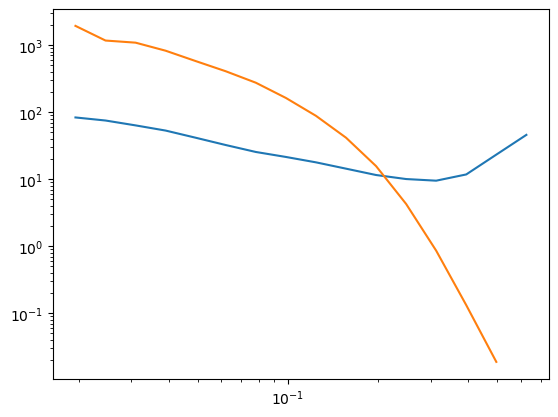

In [19]:
plt.loglog(kmags, pspec_binned)
plt.loglog(kmags, pspec1d)